In [ ]:
import os
DATA_DIR = '/home/choi4624/vscode/lib/anomalib'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    !git clone https://github.com/openvinotoolkit/anomalib.git
    %cd anomalib
    !pip install -e . -q

Cloning into 'anomalib'...
remote: Enumerating objects: 29610, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (876/876), done.
remote: Total 29610 (delta 839), reused 1064 (delta 604), pack-reused 28076
Receiving objects: 100% (29610/29610), 1.50 GiB | 22.21 MiB/s, done.
Resolving deltas: 100% (16411/16411), done.
/home/choi4624/vscode/gitclone/SWbootProject_2023-7/2nd_cnn/anomalib
^C
ERROR: Operation cancelled by user


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content

In [14]:
%cd /content/anomalib/anomalib-main

/content/anomalib/anomalib-main


In [10]:
import zipfile
with zipfile.ZipFile('/content/anomalib-main.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/anomalib')

In [ ]:
%pip install anomalib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install openvino

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 43.1 MB/s eta 0:00:00


In [ ]:
%cd /home/choi4624/vscode/gitclone/SWbootProject_2023-7/2nd_cnn/anomalib

/home/choi4624/vscode/gitclone/SWbootProject_2023-7/2nd_cnn/anomalib


In [15]:
%pip install -e . -q

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.0/198.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.6/581.6 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [16]:
%pip install wandb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, pprint, yaml, warnings, math, glob, cv2, random, logging

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")

import anomalib
from pytorch_lightning import Trainer, seed_everything
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

2.0.1+cu118
11.8
8700
True
1
0
Tesla T4


In [3]:
CONFIG_PATHS = '/content/anomalib/anomalib-main/src/anomalib/models'
MODEL_CONFIG_PAIRS = {
    'patchcore': f'{CONFIG_PATHS}/patchcore/config.yaml',
    'padim':     f'{CONFIG_PATHS}/padim/config.yaml',
    'cflow':     f'{CONFIG_PATHS}/cflow/config.yaml',
    'dfkde':     f'{CONFIG_PATHS}/dfkde/config.yaml',
    'dfm':       f'{CONFIG_PATHS}/dfm/config.yaml',
    'ganomaly':  f'{CONFIG_PATHS}/ganomaly/config.yaml',
    'stfpm':     f'{CONFIG_PATHS}/stfpm/config.yaml',
    'fastflow':  f'{CONFIG_PATHS}/fastflow/config.yaml',
    'draem':     f'{CONFIG_PATHS}/draem/config.yaml',
    'reverse_distillation': f'{CONFIG_PATHS}/reverse_distillation/config.yaml',
}

In [4]:
MODEL = 'patchcore' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
print(open(os.path.join(MODEL_CONFIG_PAIRS[MODEL]), 'r').read())

dataset:
  name: mvtec
  format: mvtec
  path: ./datasets/MVTec
  task: segmentation
  category: bottle
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: 224 # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name

In [6]:
new_update = {
    "path": '/content/drive/MyDrive/colab/mvtec_anomaly_detection',
    'category': 'hazelnut',
    'image_size': 256,
    'train_batch_size':48,
    'seed': 101
}

In [7]:
# update yaml key's value
def update_yaml(old_yaml, new_yaml, new_update):
    # load yaml
    with open(old_yaml) as f:
        old = yaml.safe_load(f)

    temp = []
    def set_state(old, key, value):
        if isinstance(old, dict):
            for k, v in old.items():
                if k == 'project':
                    temp.append(k)
                if k == key:
                    if temp and k == 'path':
                        # right now, we don't wanna change `project.path`
                        continue
                    old[k] = value
                elif isinstance(v, dict):
                    set_state(v, key, value)

    # iterate over the new update key-value pari
    for key, value in new_update.items():
        set_state(old, key, value)

    # save the updated / modified yaml file
    with open(new_yaml, 'w') as f:
        yaml.safe_dump(old, f, default_flow_style=False)

In [8]:
# let's set a new path location of new config file
new_yaml_path = CONFIG_PATHS + '/' + list(MODEL_CONFIG_PAIRS.keys())[0] + '_new.yaml'

# run the update yaml method to update desired key's values
update_yaml(MODEL_CONFIG_PAIRS[MODEL], new_yaml_path, new_update)

In [9]:
with open(new_yaml_path) as f:
    updated_config = yaml.safe_load(f)
pprint.pprint(updated_config) # check if it's updated

{'dataset': {'category': 'hazelnut',
             'center_crop': 224,
             'eval_batch_size': 32,
             'format': 'mvtec',
             'image_size': 256,
             'name': 'mvtec',
             'normalization': 'imagenet',
             'num_workers': 8,
             'path': '/content/drive/MyDrive/colab/mvtec_anomaly_detection',
             'task': 'segmentation',
             'test_split_mode': 'from_dir',
             'test_split_ratio': 0.2,
             'tiling': {'apply': False,
                        'random_tile_count': 16,
                        'remove_border_count': 0,
                        'stride': None,
                        'tile_size': None,
                        'use_random_tiling': False},
             'train_batch_size': 48,
             'transform_config': {'eval': None, 'train': None},
             'val_split_mode': 'same_as_test',
             'val_split_ratio': 0.5},
 'logging': {'log_graph': False, 'logger': []},
 'metrics': {'image': 

In [10]:
if updated_config['project']['seed'] != 0:
    print(updated_config['project']['seed'])
    seed_everything(updated_config['project']['seed'])

INFO:lightning_fabric.utilities.seed:Global seed set to 101


101


In [11]:
# It will return the configurable parameters in DictConfig object.
config = get_configurable_parameters(
    model_name=updated_config['model']['name'],
    config_path=new_yaml_path
)

In [12]:
# pass the config file to model, logger, callbacks and datamodule
model      = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks  = get_callbacks(config)
datamodule = get_datamodule(config)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/wide_resnet50_racm-8234f177.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_racm-8234f177.pth


In [13]:
# start training
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training e

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [14]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │            1.0            │
│        pixel_AUROC        │    0.9840905070304871     │
│       pixel_F1Score       │    0.6174152493476868     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_F1Score': 0.6174152493476868,
  'pixel_AUROC': 0.9840905070304871,
  'image_F1Score': 1.0,
  'image_AUROC': 1.0}]

In [31]:
RESULT_PATH = os.path.join(
    updated_config['project']['path'],
    updated_config['model']['name'],
    updated_config['dataset']['format'],
    updated_config['dataset']['category']
)
RESULT_PATH

'./results/patchcore/mvtec/hazelnut'

In [16]:
# a simple function to visualize the model's prediction (anomaly heatmap)
def vis(paths, n_images, is_random=True, figsize=(16, 16)):
    for i in range(n_images):
        image_name = paths[i]
        if is_random: image_name = random.choice(paths)
        img = cv2.imread(image_name)[:,:,::-1]

        category_type = image_name.split('/')[-4:-3:][0]
        defected_type = image_name.split('/')[-2:-1:][0]

        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.title(
            f"Category : {category_type} and Defected Type : {defected_type}",
            fontdict={'fontsize': 20, 'fontweight': 'medium'}
        )
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [36]:
import os
import glob

In [58]:
glob.glob(os.path.join(RESULT_PATH, content, '**',  '*.png'), recursive=True)

['./results/patchcore/mvtec/hazelnut/run/images/image_ROC.png',
 './results/patchcore/mvtec/hazelnut/run/images/pixel_ROC.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/005.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/003.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/007.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/027.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/038.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/019.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/022.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/023.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/037.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/020.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/001.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/004.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/011.png',
 './results/patchcore/mvtec/hazelnut/run/images/good/

In [61]:
for content in os.listdir(RESULT_PATH):
    #if content == 'images':
        full_path = glob.glob(os.path.join(RESULT_PATH, content, '**',  '*.png'), recursive=True)
        print('Total Image ', len(full_path))
        print(full_path[0].split('/'))
        print(full_path[0].split('/')[-2:-1:])
        print(full_path[0].split('/')[-4:-3:])

Total Image  112
['.', 'results', 'patchcore', 'mvtec', 'hazelnut', 'run', 'images', 'image_ROC.png']
['images']
['hazelnut']


In [56]:

def get_all_images():
    for content in os.listdir(RESULT_PATH):
        if content == 'images':
            full_paths += glob.glob(os.path.join(RESULT_PATH, content, '**', '*.png'), recursive=True)
            print('Total Image ', len(full_path))
            print(full_path[0].split('/'))
            print(full_path[0].split('/')[-2:-1:])
            print(full_path[0].split('/')[-4:-3:])




In [54]:
full_paths = get_all_images()

In [52]:
os.listdir(RESULT_PATH+'/run/images')

['good', 'crack', 'cut', 'print', 'image_ROC.png', 'hole', 'pixel_ROC.png']

In [55]:
full_paths

[]

In [43]:
print(full_paths)

None


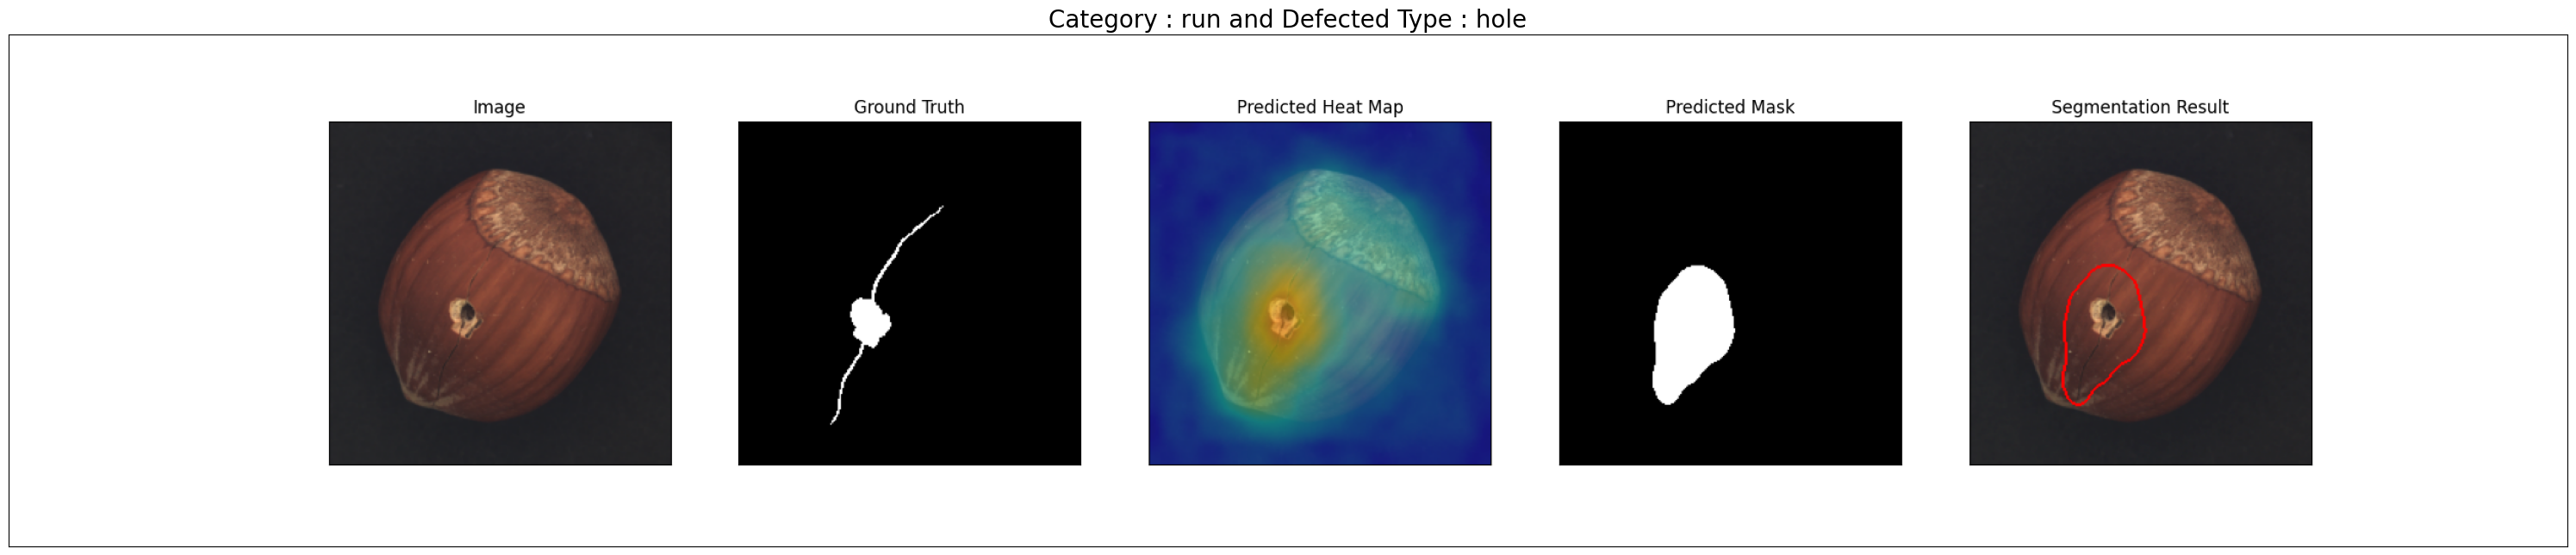

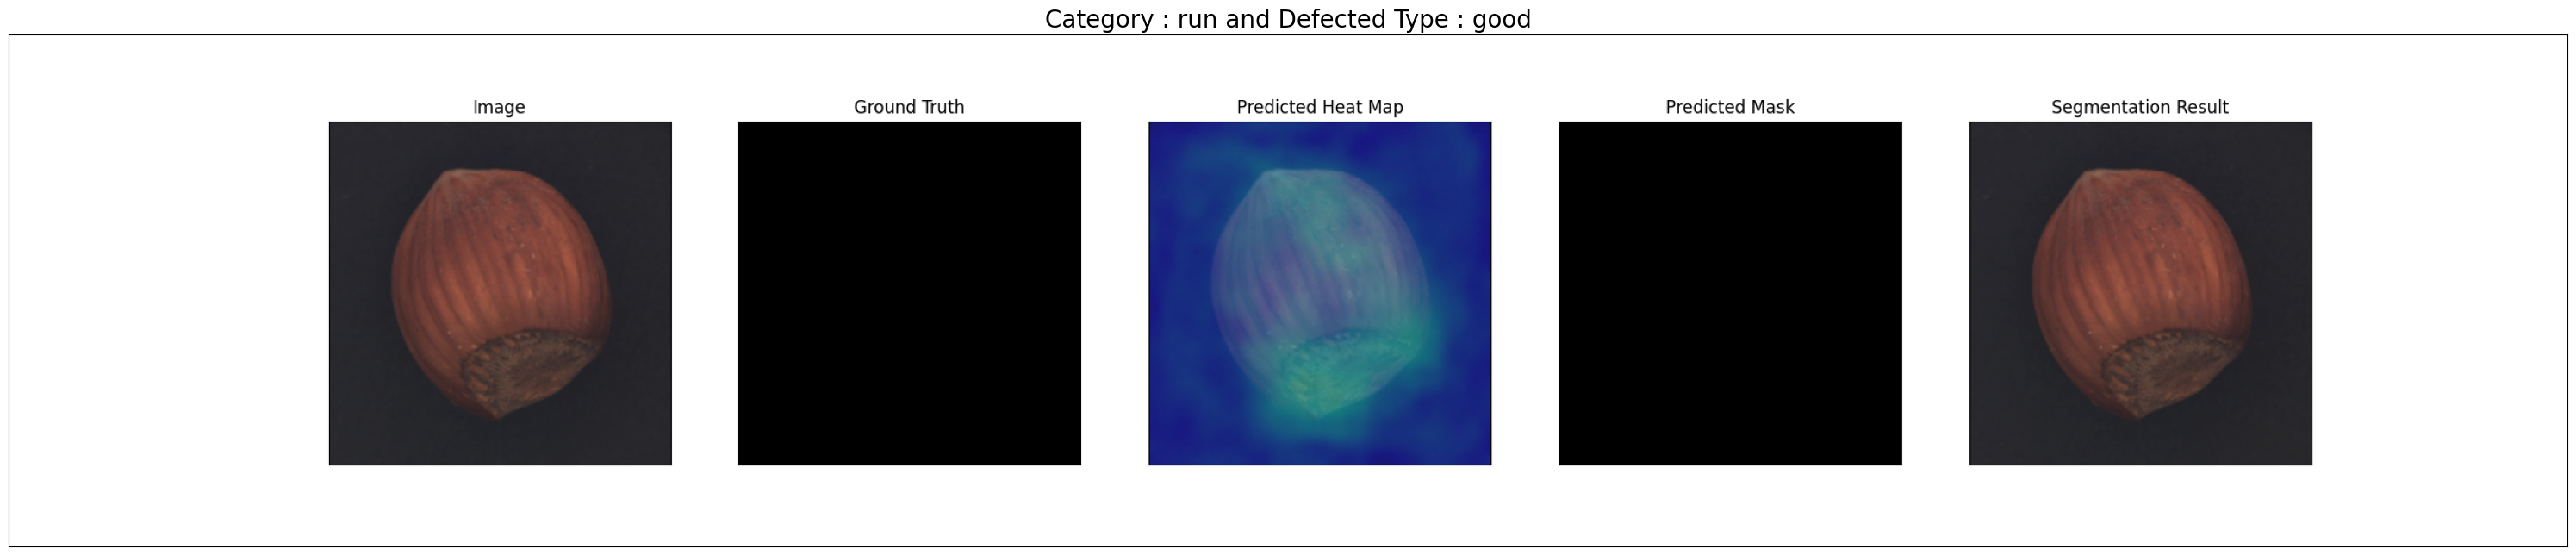

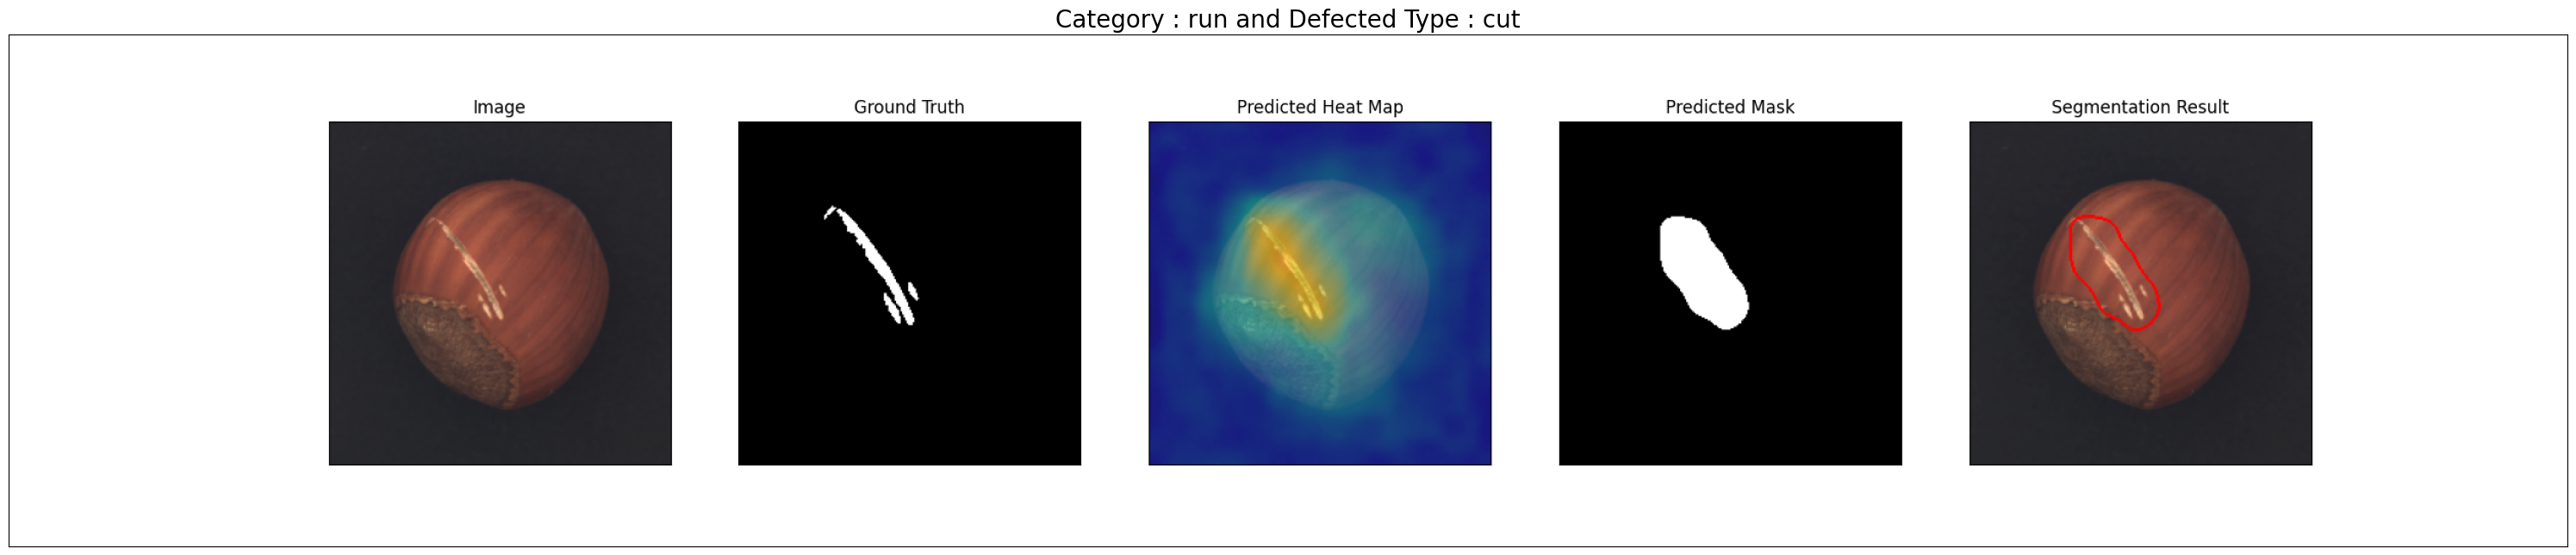

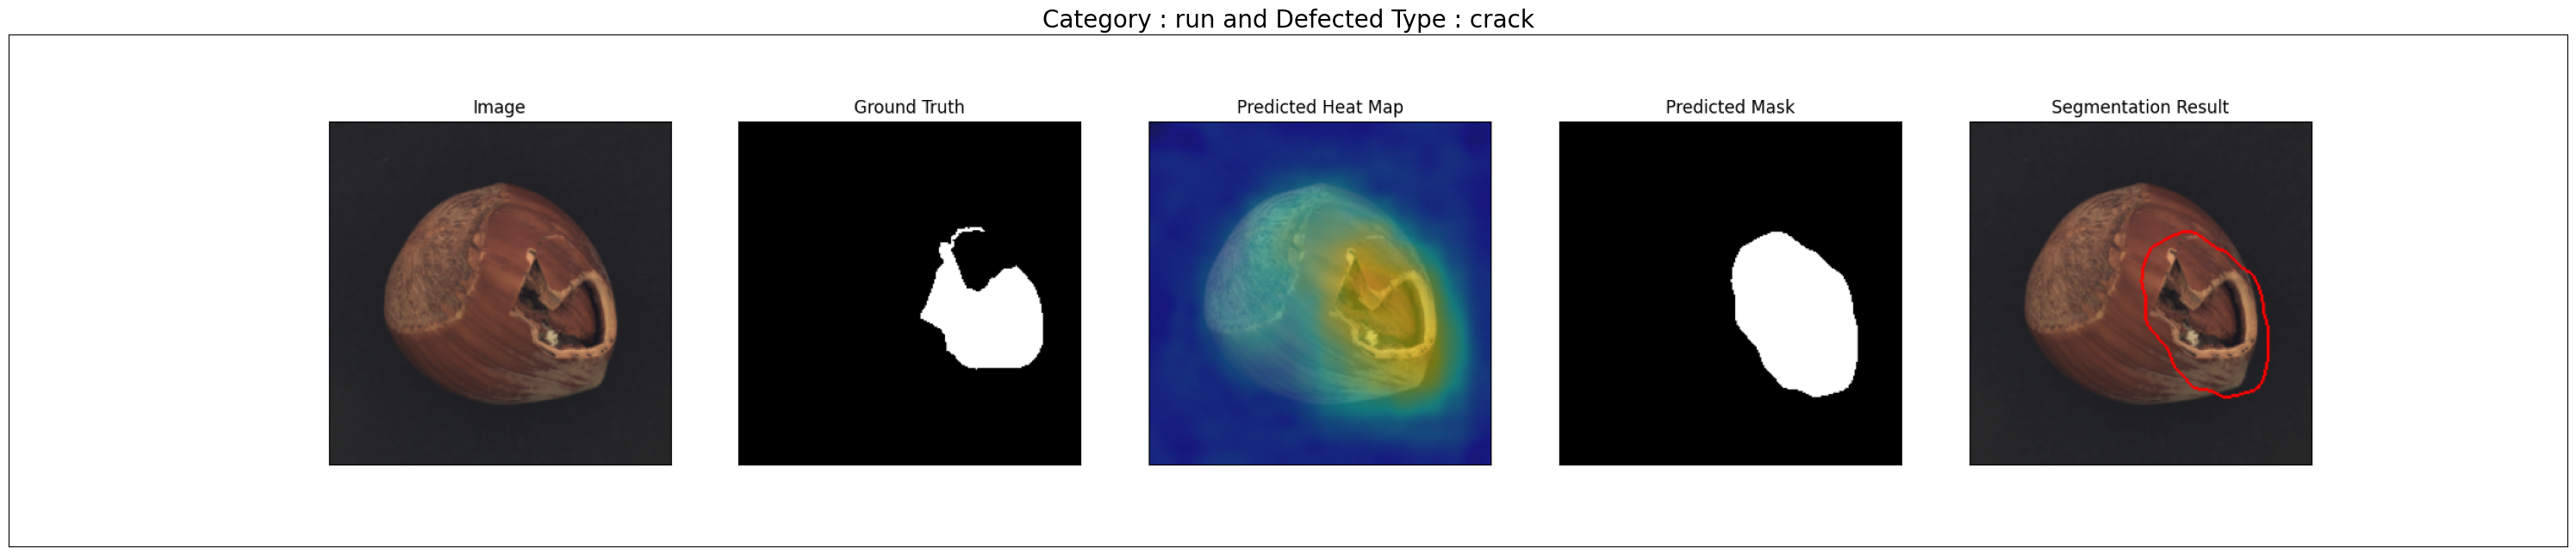

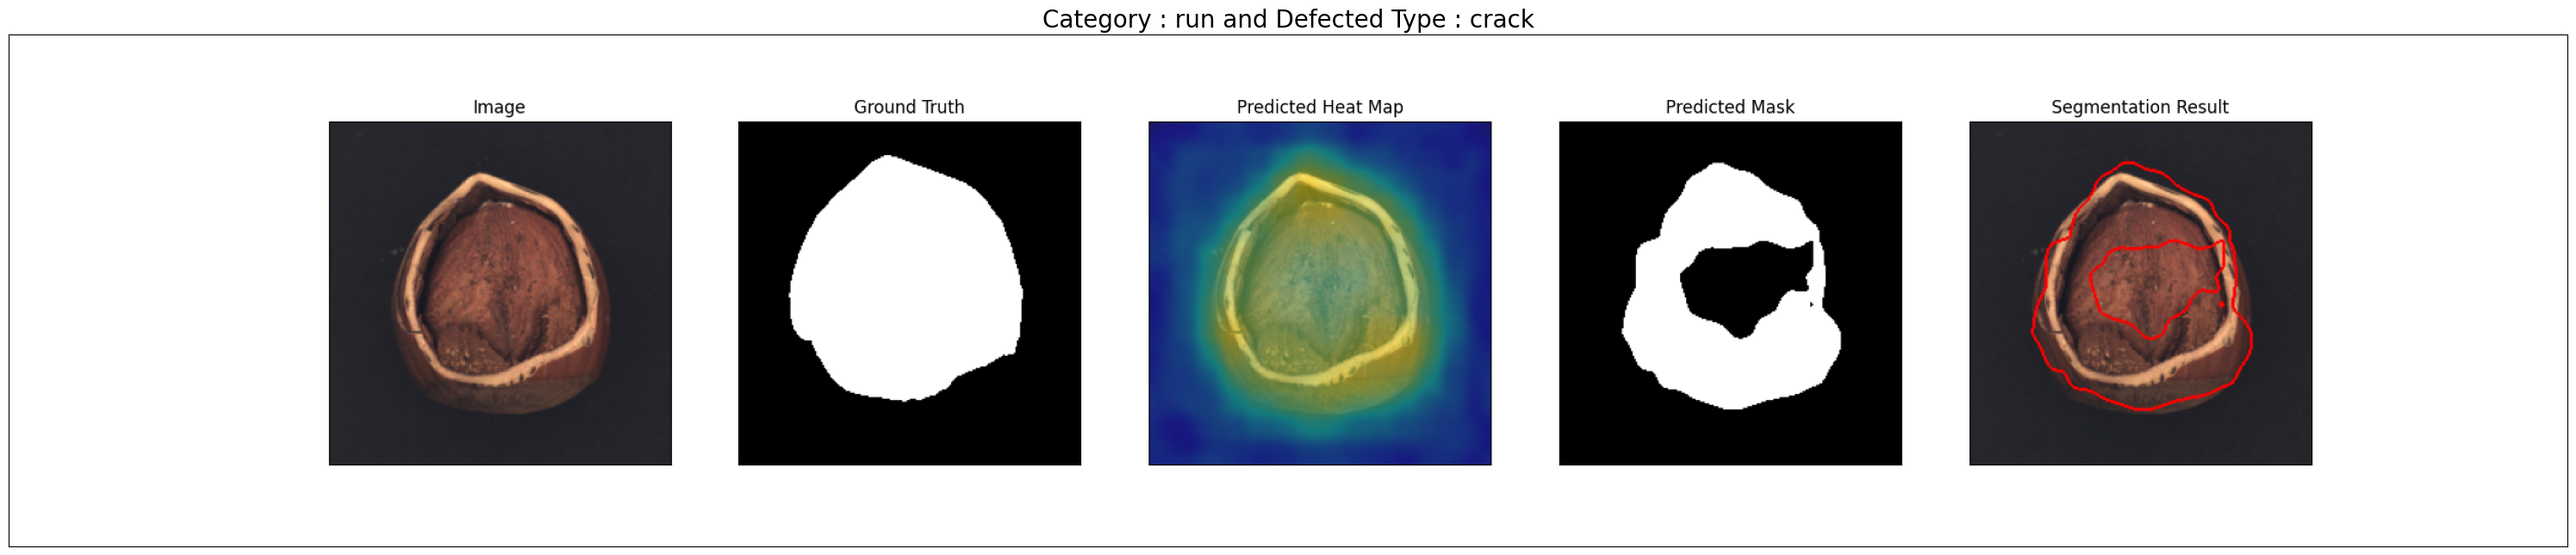

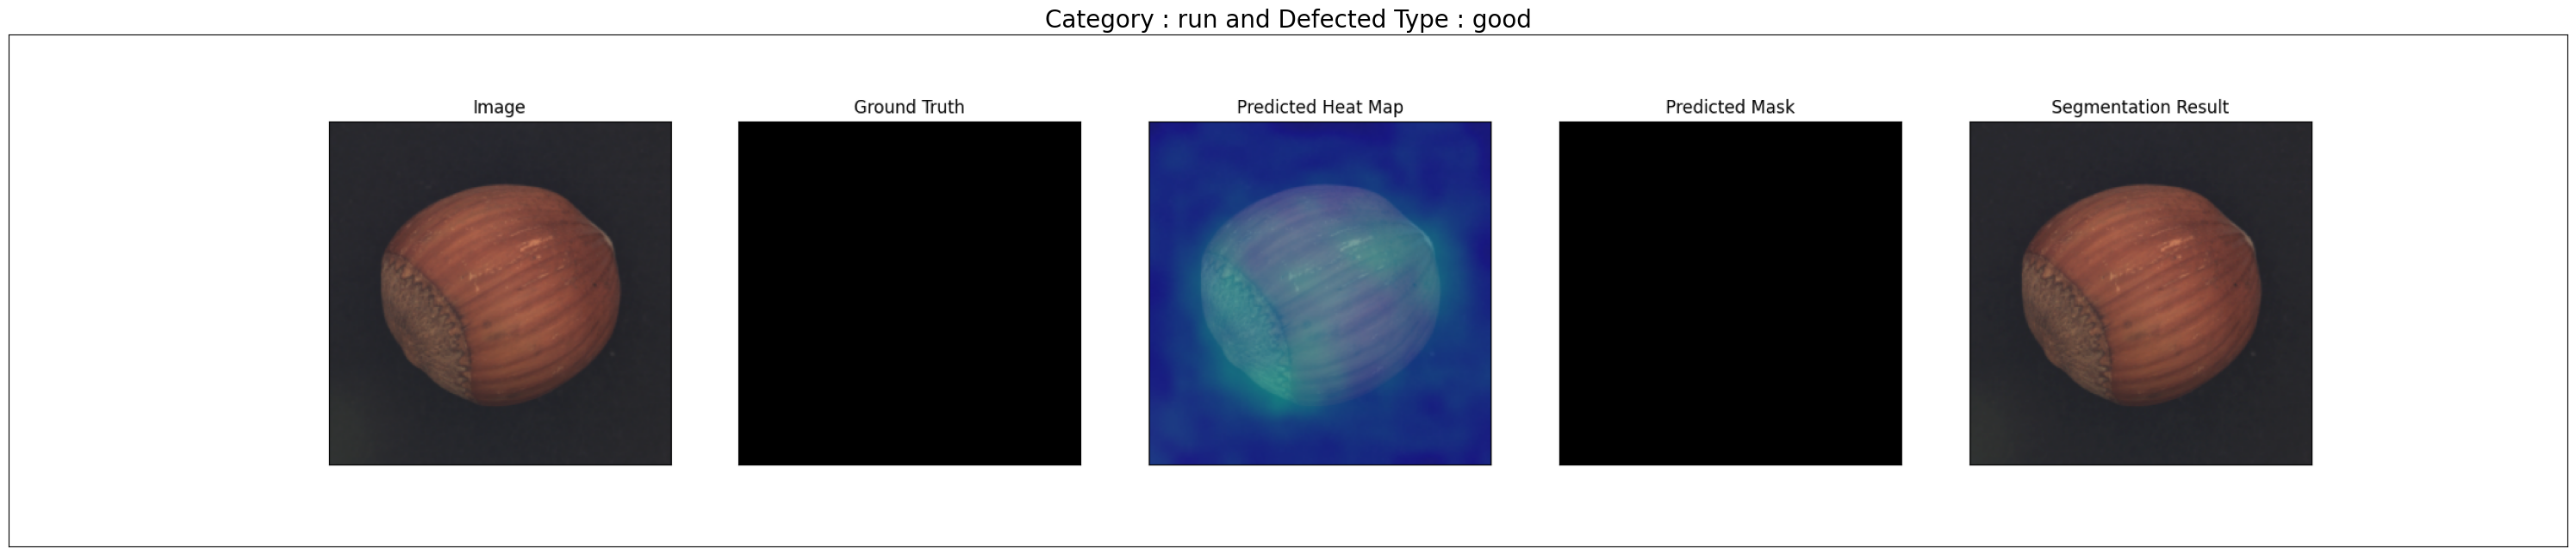

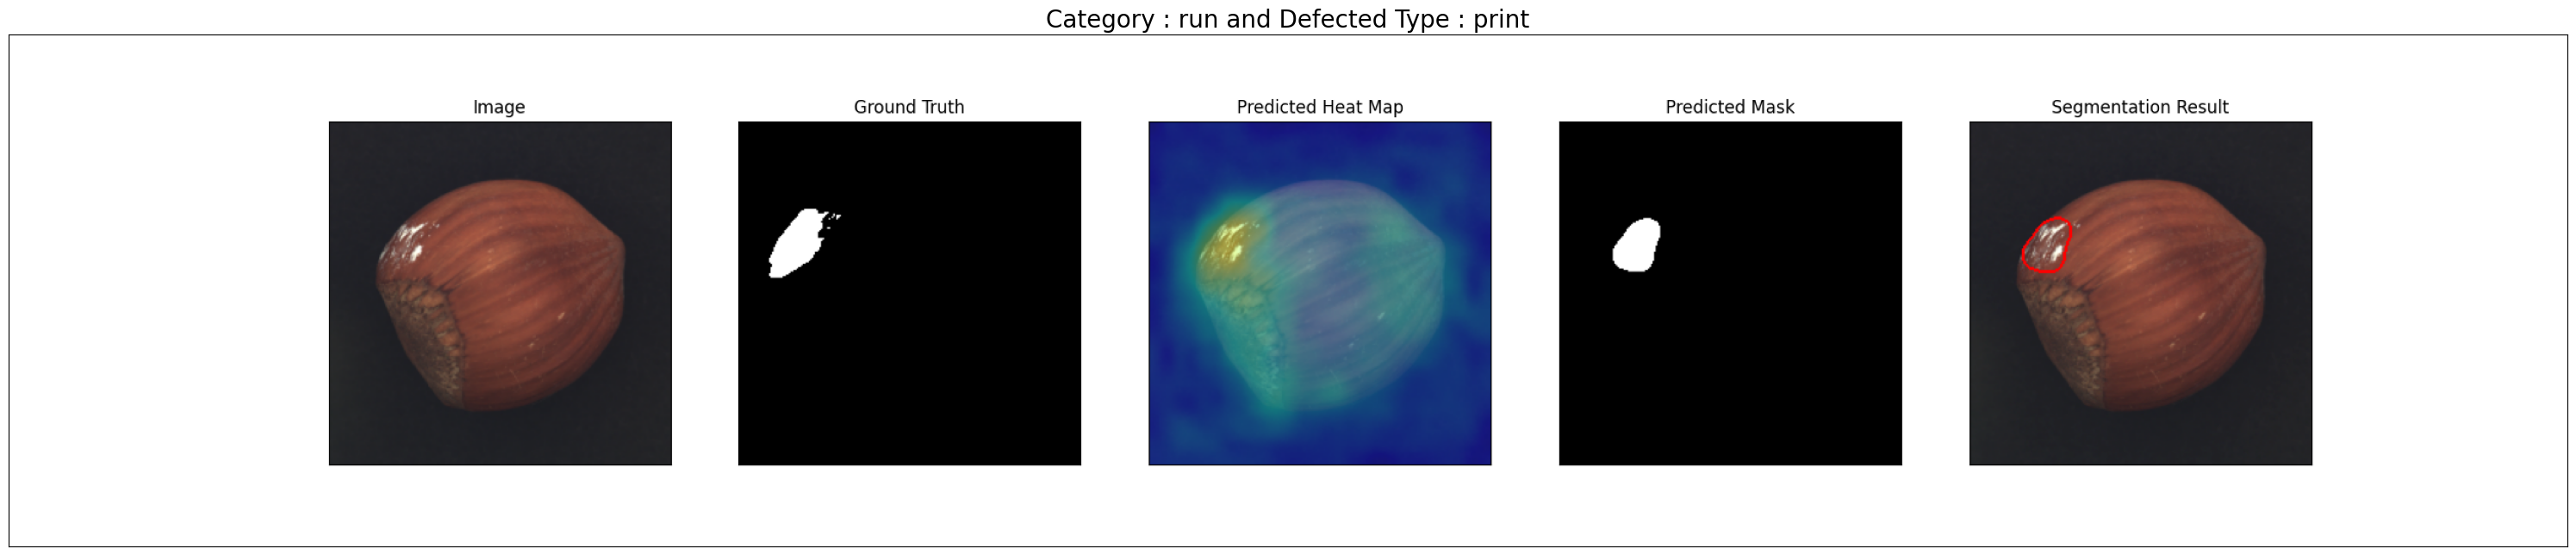

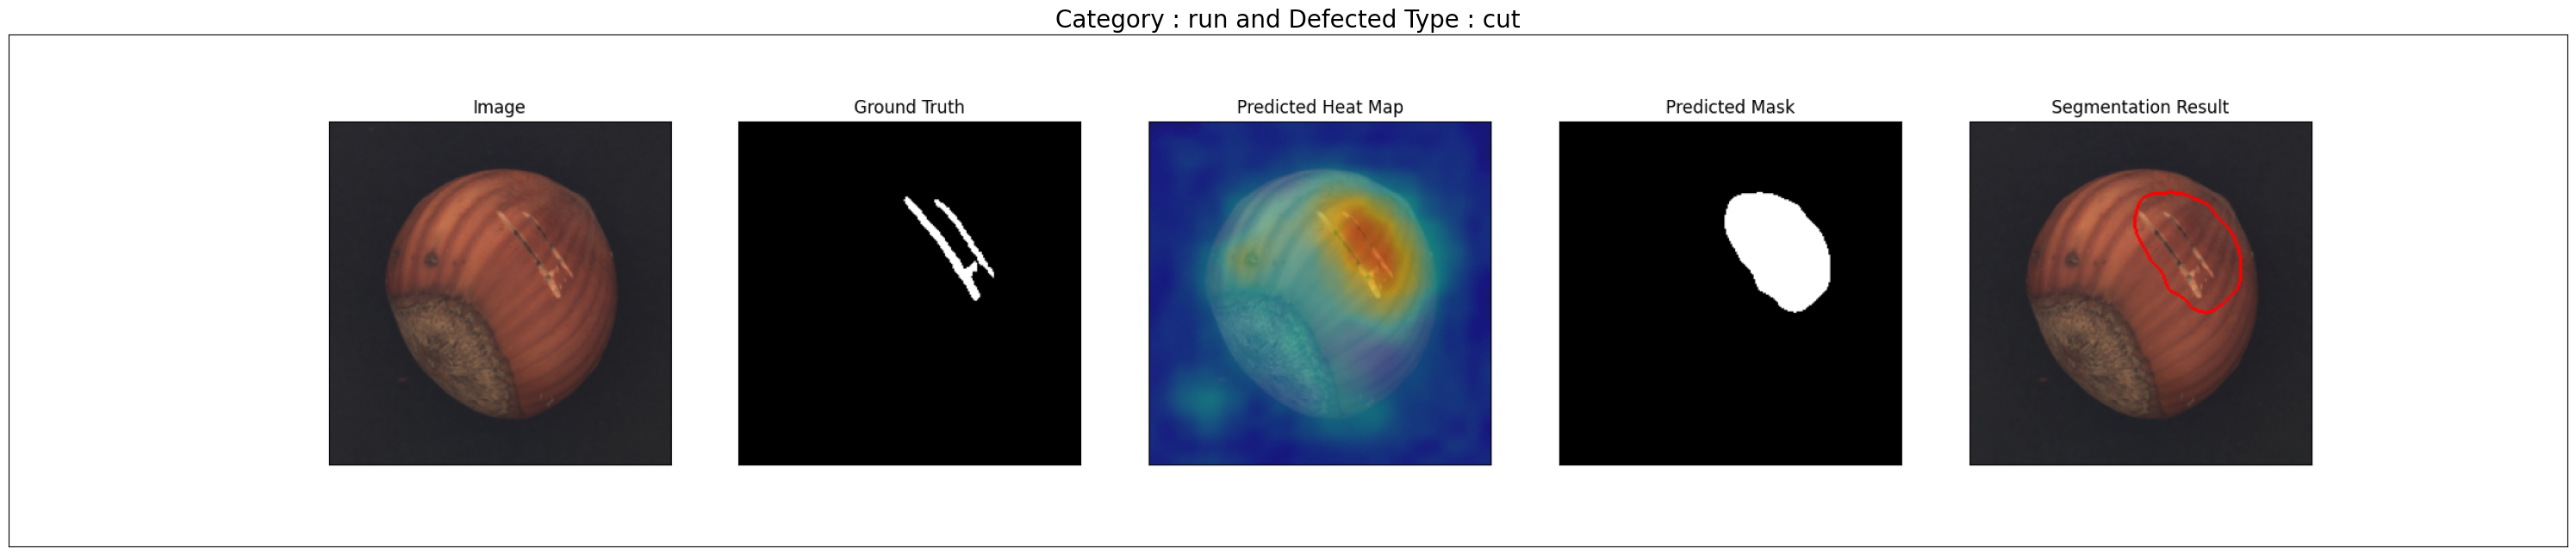

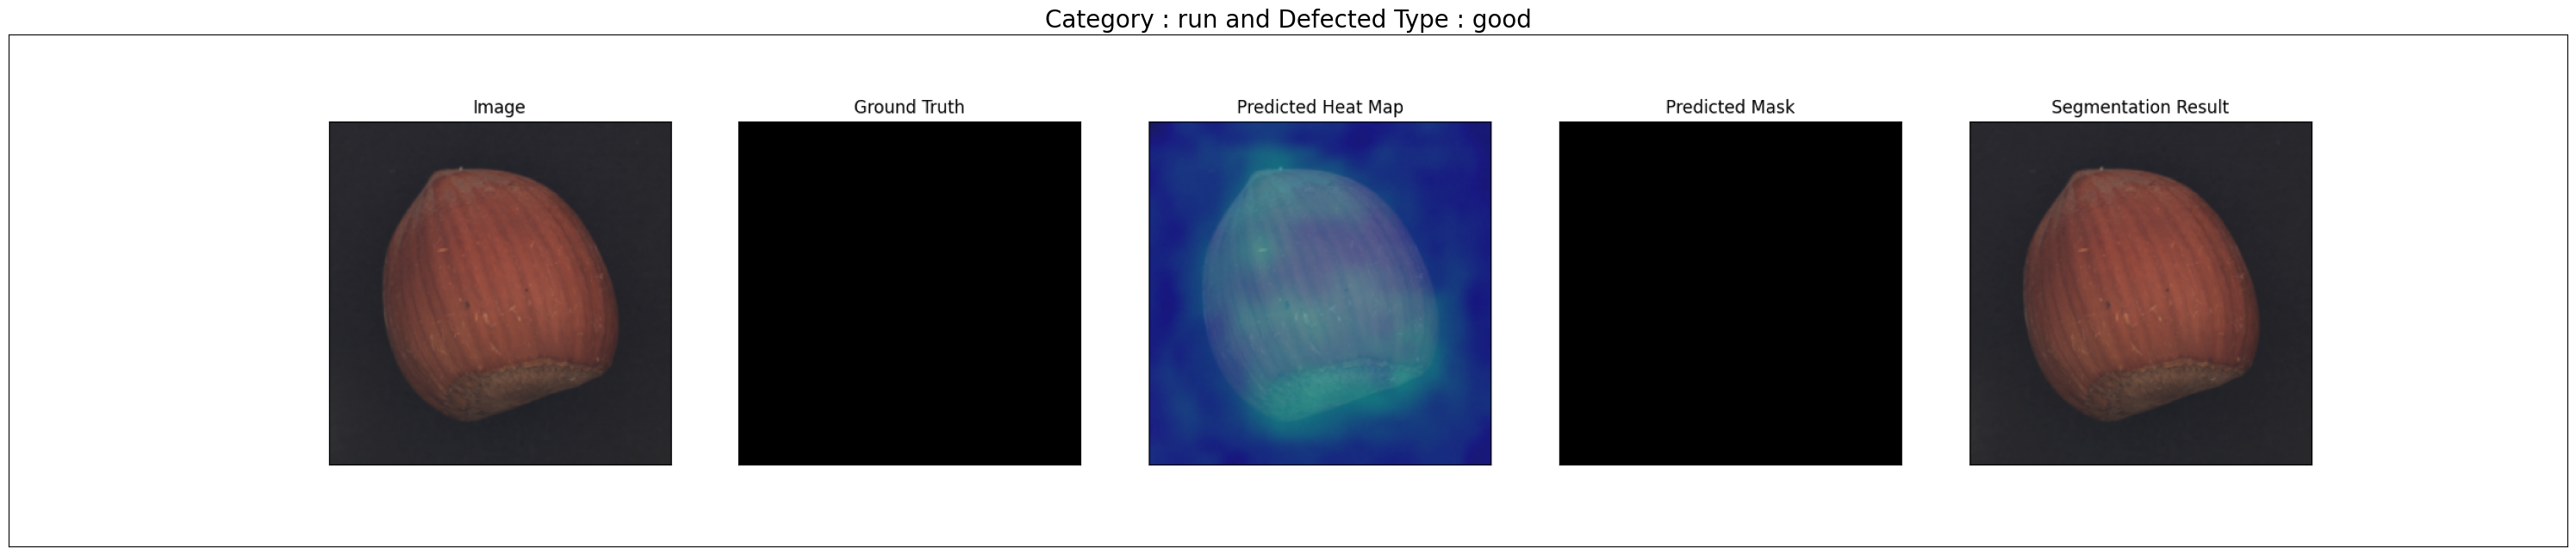

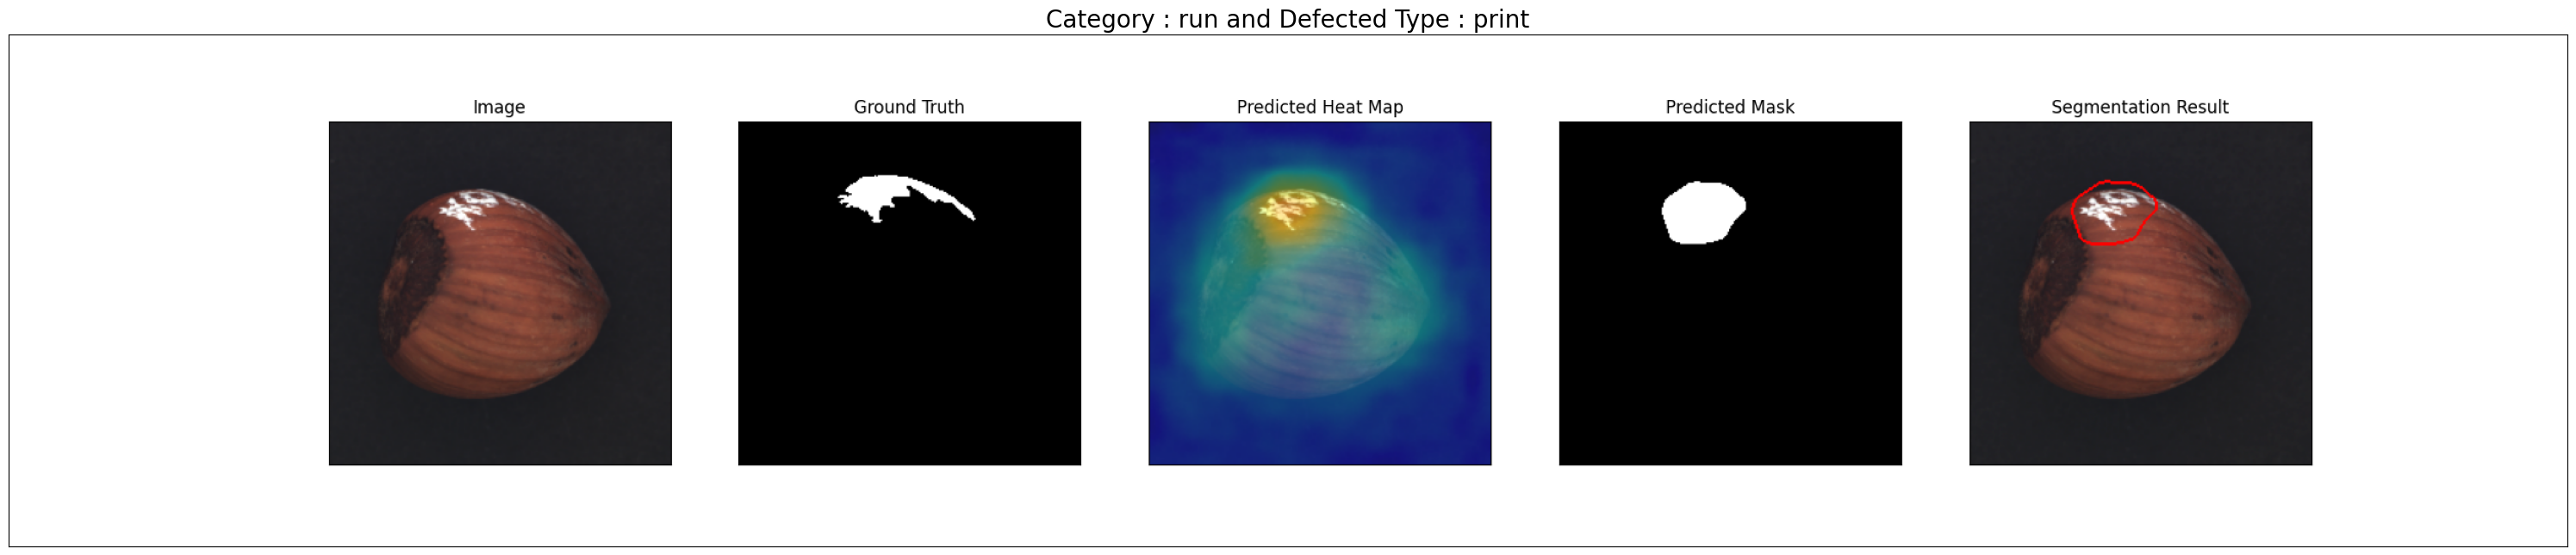

In [62]:
vis(full_path, 10, is_random=True, figsize=(30, 30))

In [64]:
import shutil
shutil.make_archive('results-anmalib', 'zip', '/content/results')

'/content/results-anmalib.zip'

In [ ]:
with open('/content/drive/My Drive/sample.txt', 'w') as f:
  f.write('Hello, World!')

In [65]:
%cd /content

/content


In [66]:
!cp -r '/content/results-anmalib.zip' /content/drive/MyDrive/colab/results